In [1]:
import json
import datetime

import pandas as pd
import matplotlib.pyplot as plt
from alarms.utils import create_plot, combine_hours_into_sleep_periods, AnalysisArea, group_alerts_by_hour

# Set colors for the Pycharm dark theme (disable if you don't use Pycharm or use light theme)
# Also disable, when saving images (to avoid white font)
PYCHARM_DARK_THEME = False
if PYCHARM_DARK_THEME:
    COLOR = '#ffffff'
    plt.rcParams.update({'text.color': COLOR})
    plt.rcParams.update({'axes.labelcolor': COLOR})
    plt.rcParams.update({'xtick.color': COLOR})
    plt.rcParams.update({'ytick.color': COLOR})

In [2]:
# Set area to process
SELECTED_REGION = AnalysisArea.LVIV
# Set styling
PLOT_COLOR_LIGHT = "#d25f5f"
PLOT_COLOR_DARK = "#681010"
# Set saving settings
SAVE = False
ANIMATE = False

In [3]:
# Load data into dataframe
if SELECTED_REGION == AnalysisArea.ALL_UKRAINE:
    filename = "ukraine_alarms.json"
if SELECTED_REGION == AnalysisArea.LVIV:
    filename = "lviv_alarms.json"
with open(f"processed_data/{filename}", "r") as f:  # NOQA
    all_alarms_df = pd.DataFrame.from_dict(json.loads(f.read()))
    all_alarms_df["start_datetime"] = pd.to_datetime(all_alarms_df["start_datetime"], unit='ms')
    all_alarms_df["end_datetime"] = pd.to_datetime(all_alarms_df["end_datetime"], unit='ms')

In [4]:
# Alerts per region
agg_params = {
    'start_datetime': ['count'],
    'duration_hours': ['sum']
}
alerts_per_region = all_alarms_df.groupby(all_alarms_df["region"]).agg(agg_params)
alerts_per_region.columns = ["alerts", "duration_hours"]
alerts_per_region.reset_index(inplace=True)
if SELECTED_REGION == AnalysisArea.ALL_UKRAINE:
    # No registered official Crimea alerts on API
    alerts_per_region.loc[len(alerts_per_region)] = ['Crimea', 0, 0]
    alerts_per_region.loc[len(alerts_per_region)] = ['Sevastopol region', 0, 0]
alerts_per_region

,region,alerts,duration_hours
0,Lviv region,195,188.565


In [5]:
if SELECTED_REGION == AnalysisArea.ALL_UKRAINE:
    alerts_per_region = alerts_per_region.sort_values(by="alerts", ascending=True)
    create_plot(
        alerts_per_region, 'region', 'alerts',
        first_hex=PLOT_COLOR_LIGHT, last_hex=PLOT_COLOR_DARK,
        plot_title="Regions with the most air alerts and shelling (Ukraine)",
        y_label="Regions", x_label="Alerts",
        save=SAVE, animate=ANIMATE,
        plot_color_column='duration_hours', plot_color_column_label='Hours (darker means more)'
    )

In [6]:
# Filter by a specific region, if needed
alarms_df = all_alarms_df.copy(deep=True)
if SELECTED_REGION == AnalysisArea.LVIV:
    FILTER_BY_REGION = "Lviv region"
    TOTAL_DAYS = (datetime.date(2022, 9, 14) - datetime.date(2022, 2, 25)).days
if SELECTED_REGION == AnalysisArea.ALL_UKRAINE:
    FILTER_BY_REGION = "Kharkiv region"
    TOTAL_DAYS = (datetime.date(2022, 9, 14) - datetime.date(2022, 3, 13)).days
    alarms_df.drop(alarms_df[alarms_df["region"] != FILTER_BY_REGION].index, inplace=True)

In [7]:
# Alerts by date
agg_params = {'duration_hours': ['sum'], 'start_message': ['count']}
most_alerts_by_date = alarms_df.groupby(alarms_df["start_datetime"].dt.date).agg(agg_params)
most_alerts_by_date.columns = most_alerts_by_date.columns.droplevel(1)
most_alerts_by_date.columns = ["duration_hours", "alerts"]
# Average stats
TOTAL_ALERTS = most_alerts_by_date["alerts"].sum()
average_alerts_per_day = (TOTAL_ALERTS / TOTAL_DAYS).round(2)  # NOQA
total_hours = most_alerts_by_date["duration_hours"].sum()
average_hours_per_day = (total_hours / TOTAL_DAYS).round(2)
print(f"- On average ({FILTER_BY_REGION}), we have {average_alerts_per_day} air alerts per day.")  # NOQA
print(f"- On average ({FILTER_BY_REGION}), we've spent {average_hours_per_day} hours per day in bomb shelters.")
print(f"- In total ({FILTER_BY_REGION}), we had {TOTAL_ALERTS} air alerts.")
print(f"- In total ({FILTER_BY_REGION}), we've spent {total_hours.round()} hours in bomb shelters.")
# Plot
most_alerts_by_date = most_alerts_by_date.nlargest(25, 'alerts').sort_values(by="start_datetime", ascending=False)
most_alerts_by_date

- On average (Lviv region), we have 0.97 air alerts per day.
- On average (Lviv region), we've spent 0.94 hours per day in bomb shelters.
- In total (Lviv region), we had 195 air alerts.
- In total (Lviv region), we've spent 189.0 hours in bomb shelters.


,duration_hours,alerts
start_datetime,,
2022-08-24,3.904444,6
2022-08-20,1.776389,3
2022-08-11,1.708611,3
2022-06-26,3.722500,3
2022-06-23,1.021111,3
2022-05-20,3.144167,3
2022-05-05,2.807778,3
2022-04-25,4.620556,4
2022-04-18,4.170278,3


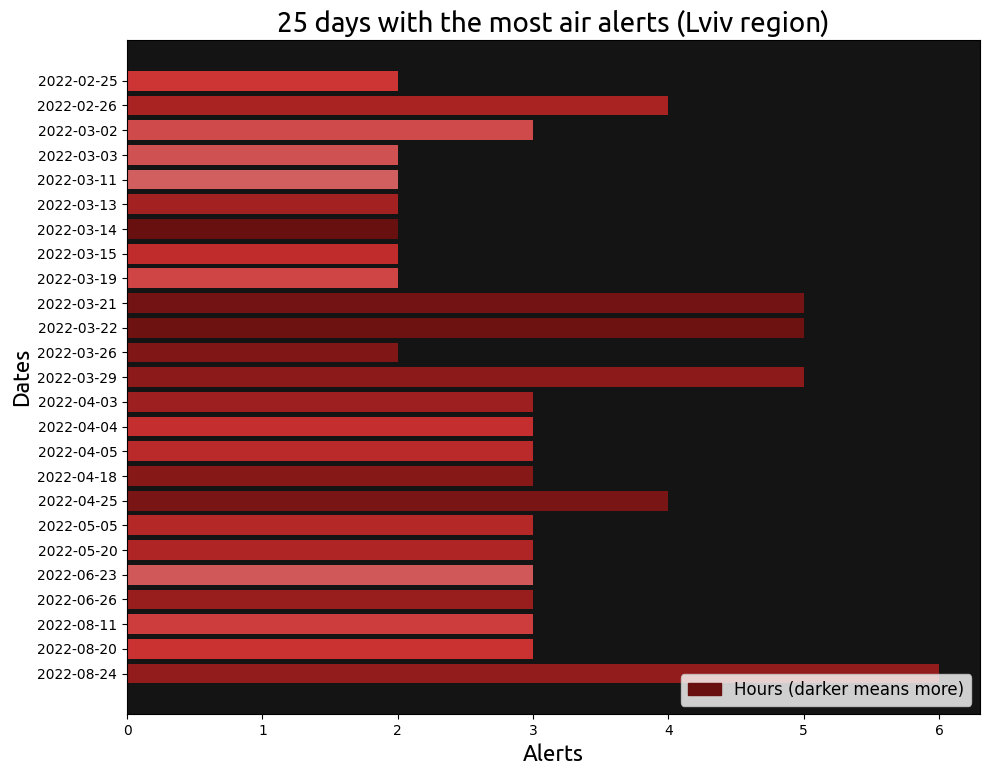

In [8]:
create_plot(
    most_alerts_by_date, 'start_datetime', 'alerts',
    first_hex=PLOT_COLOR_LIGHT, last_hex=PLOT_COLOR_DARK,
    plot_title=f"25 days with the most air alerts ({FILTER_BY_REGION})",
    y_label="Dates", x_label="Alerts",
    save=SAVE, animate=ANIMATE,
    plot_color_column='duration_hours', plot_color_column_label='Hours (darker means more)'
)

In [9]:
# Alerts by month
months = ["January", "February", "March", "April", "May", "June",
            "July", "August", "September", "October", "November", "December"]
agg_params = {'start_datetime': ['count'], 'duration_hours': ['sum']}
alerts_by_month = alarms_df.groupby(alarms_df["start_datetime"].dt.month).agg(agg_params)
alerts_by_month.reset_index(inplace=True)
alerts_by_month.columns = ["month", "alerts_per_month", "duration_hours"]
alerts_by_month['month'] = alerts_by_month['month'].apply(lambda x: months[x-1])
# Dropping September, as only first 14 days of September are covered
alerts_by_month.drop(alerts_by_month[alerts_by_month["month"] == "September"].index, inplace=True)
alerts_by_month = alerts_by_month.sort_index(ascending=False)
alerts_by_month

,month,alerts_per_month,duration_hours
6,August,25,15.231111
5,July,20,19.280556
4,June,21,20.836667
3,May,27,29.752778
2,April,42,42.073333
1,March,47,51.238333
0,February,7,5.727500


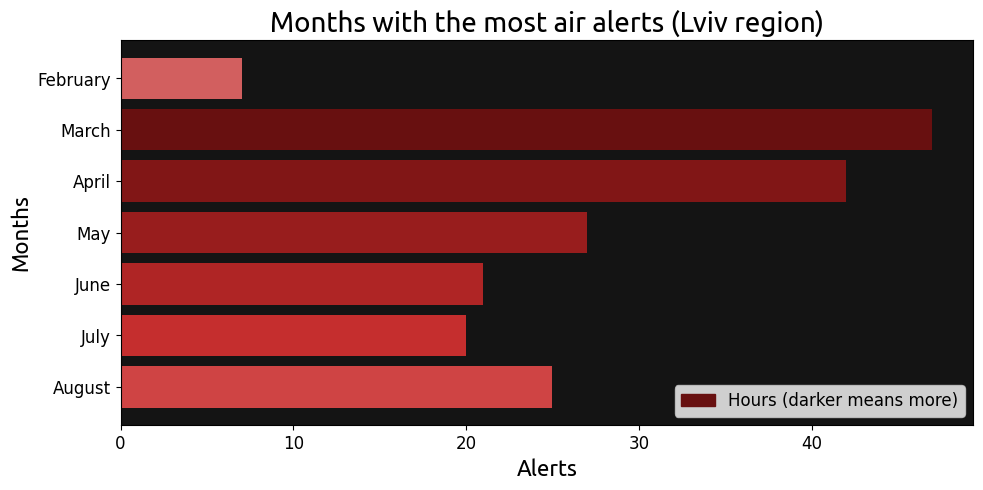

In [10]:
create_plot(
    alerts_by_month, 'month', 'alerts_per_month',
    first_hex=PLOT_COLOR_LIGHT, last_hex=PLOT_COLOR_DARK,
    plot_title=f"Months with the most air alerts ({FILTER_BY_REGION})",
    y_label="Months", x_label="Alerts",
    save=SAVE, animate=ANIMATE,
    plot_color_column='duration_hours', plot_color_column_label='Hours (darker means more)'
)

In [11]:
""# Alerts by weekday
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
agg_params = {'start_datetime': ['count'], 'duration_hours': ['sum']}
alerts_by_weekday = alarms_df.groupby(alarms_df["start_datetime"].dt.weekday).agg(agg_params)
alerts_by_weekday.reset_index(inplace=True)
alerts_by_weekday.columns = ["weekday", "alerts_per_weekday", "duration_hours"]
alerts_by_weekday["alerts_percentage"] = alerts_by_weekday["alerts_per_weekday"].apply(lambda x: x / TOTAL_ALERTS * 100)
alerts_by_weekday['weekday'] = alerts_by_weekday['weekday'].apply(lambda x: weekdays[x])
# Plot
alerts_by_weekday = alerts_by_weekday.sort_index(ascending=False)
alerts_by_weekday

,weekday,alerts_per_weekday,duration_hours,alerts_percentage
6,Sunday,24,28.105278,12.307692
5,Saturday,32,34.381111,16.410256
4,Friday,21,17.601944,10.769231
3,Thursday,28,22.995278,14.358974
2,Wednesday,28,25.925833,14.358974
1,Tuesday,34,30.930833,17.435897
0,Monday,28,28.624722,14.358974


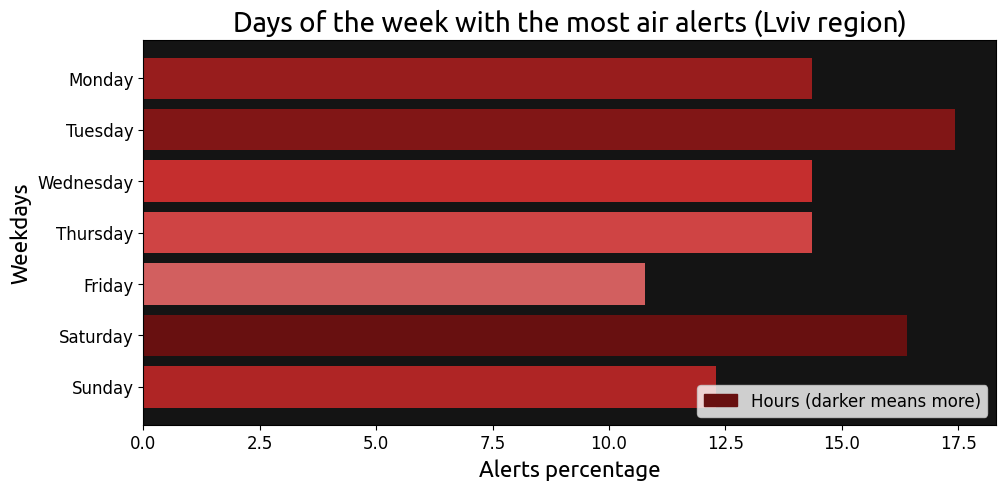

In [12]:
create_plot(
    alerts_by_weekday, 'weekday', 'alerts_percentage',
    first_hex=PLOT_COLOR_LIGHT, last_hex=PLOT_COLOR_DARK,
    plot_title=f"Days of the week with the most air alerts ({FILTER_BY_REGION})",
    y_label="Weekdays", x_label="Alerts percentage",
    save=SAVE, animate=ANIMATE,
    plot_color_column='duration_hours', plot_color_column_label='Hours (darker means more)'
)

In [13]:
# Alerts by hour of the day
alerts_by_hour = group_alerts_by_hour(alarms_df)
# Plot
alerts_by_hour = alerts_by_hour.sort_index(ascending=False)
alerts_by_hour["alerts_percentage"] = alerts_by_hour["alerts_per_hour"].apply(lambda x: x / TOTAL_ALERTS * 100)
alerts_by_hour

,hour,alerts_per_hour,duration_hours,alerts_percentage
23,23:00,10,6.340833,5.128205
22,22:00,12,8.877778,6.153846
21,21:00,9,10.553333,4.615385
20,20:00,19,19.004167,9.743590
19,19:00,11,10.082222,5.641026
18,18:00,7,7.422500,3.589744
17,17:00,10,9.333333,5.128205
16,16:00,10,13.423889,5.128205
15,15:00,6,4.214444,3.076923
14,14:00,5,2.834444,2.564103


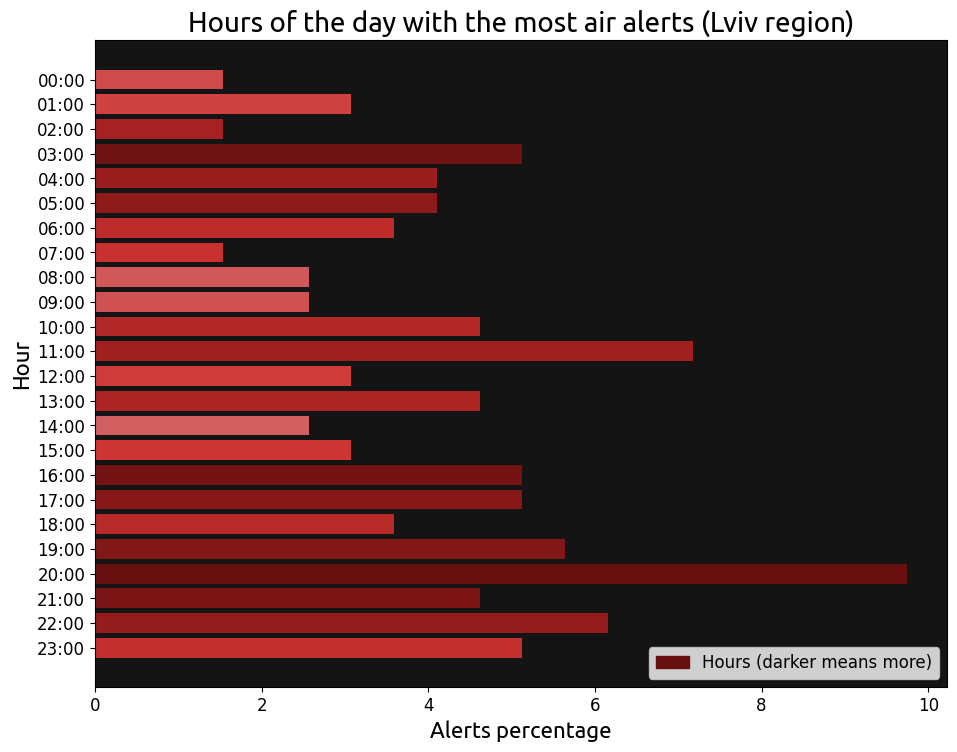

In [14]:
create_plot(
    alerts_by_hour, 'hour', 'alerts_percentage',
    first_hex=PLOT_COLOR_LIGHT, last_hex=PLOT_COLOR_DARK,
    plot_title=f"Hours of the day with the most air alerts ({FILTER_BY_REGION})",
    y_label="Hour", x_label="Alerts percentage",
    save=SAVE, animate=ANIMATE,
    plot_color_column='duration_hours', plot_color_column_label='Hours (darker means more)'
)

In [15]:
# Alerts per sleep period
alerts_per_sleep_period = combine_hours_into_sleep_periods(alerts_by_hour)
alerts_per_sleep_period = alerts_per_sleep_period.sort_index(ascending=False)
alerts_per_sleep_period

,affected_hours,alerts_per_sleep_period,hours_per_sleep_period,sleep_period,alerts_percetage_per_sleep_period
24,"[0, 1, 2, 3, 4, 5, 6, 7, 8]",53,64.443889,00:00-08:00,27.179487
23,"[23, 0, 1, 2, 3, 4, 5, 6, 7]",58,67.5575,23:00-07:00,29.743590
22,"[22, 23, 0, 1, 2, 3, 4, 5, 6]",67,71.843611,22:00-06:00,34.358974
21,"[21, 22, 23, 0, 1, 2, 3, 4, 5]",69,75.576111,21:00-05:00,35.384615
20,"[20, 21, 22, 23, 0, 1, 2, 3, 4]",80,85.450556,20:00-04:00,41.025641
19,"[19, 20, 21, 22, 23, 0, 1, 2, 3]",83,86.804167,19:00-03:00,42.564103
18,"[18, 19, 20, 21, 22, 23, 0, 1, 2]",80,77.944722,18:00-02:00,41.025641
17,"[17, 18, 19, 20, 21, 22, 23, 0, 1]",87,78.88,17:00-01:00,44.615385
16,"[16, 17, 18, 19, 20, 21, 22, 23, 0]",91,88.513056,16:00-00:00,46.666667
15,"[15, 16, 17, 18, 19, 20, 21, 22, 23]",94,89.2525,15:00-23:00,48.205128


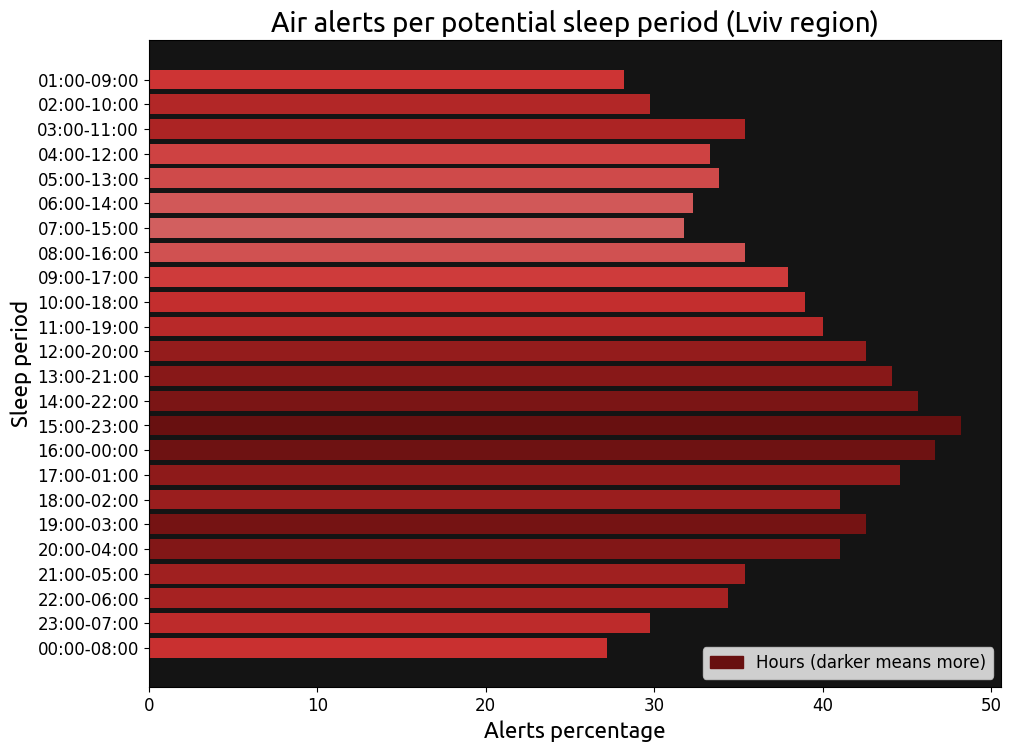

In [16]:
# Plot
create_plot(
    alerts_per_sleep_period, 'sleep_period', 'alerts_percetage_per_sleep_period',
    first_hex=PLOT_COLOR_LIGHT, last_hex=PLOT_COLOR_DARK,
    plot_title=f"Air alerts per potential sleep period ({FILTER_BY_REGION})",
    y_label="Sleep period", x_label="Alerts percentage",
    save=SAVE, animate=ANIMATE,
    plot_color_column='hours_per_sleep_period', plot_color_column_label='Hours (darker means more)'
)

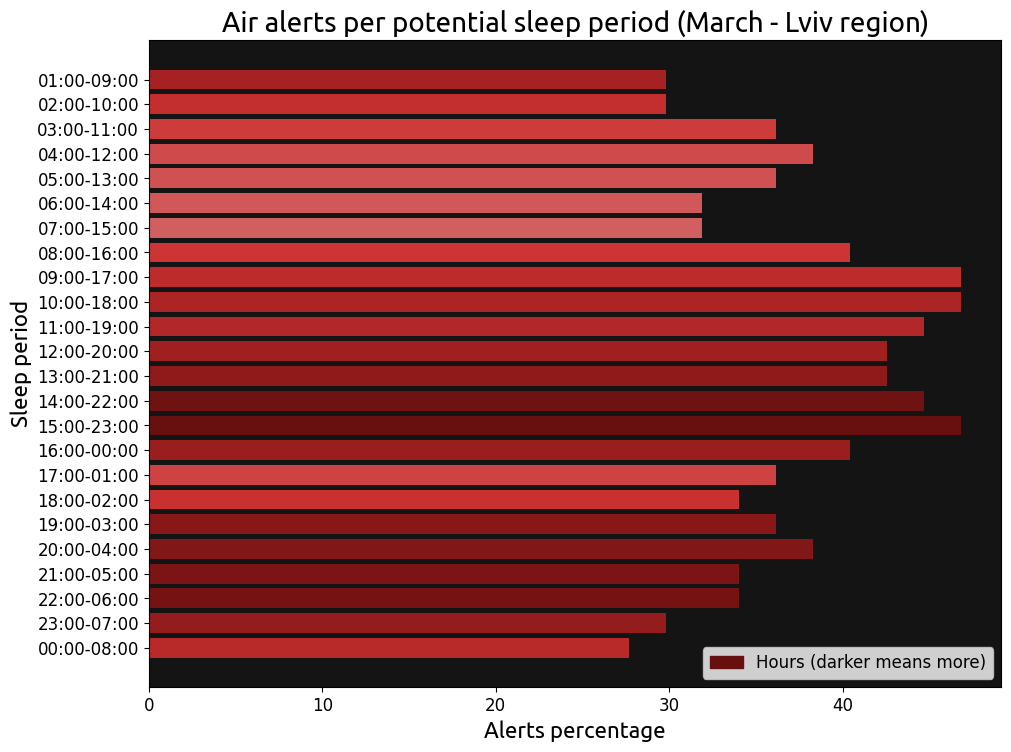

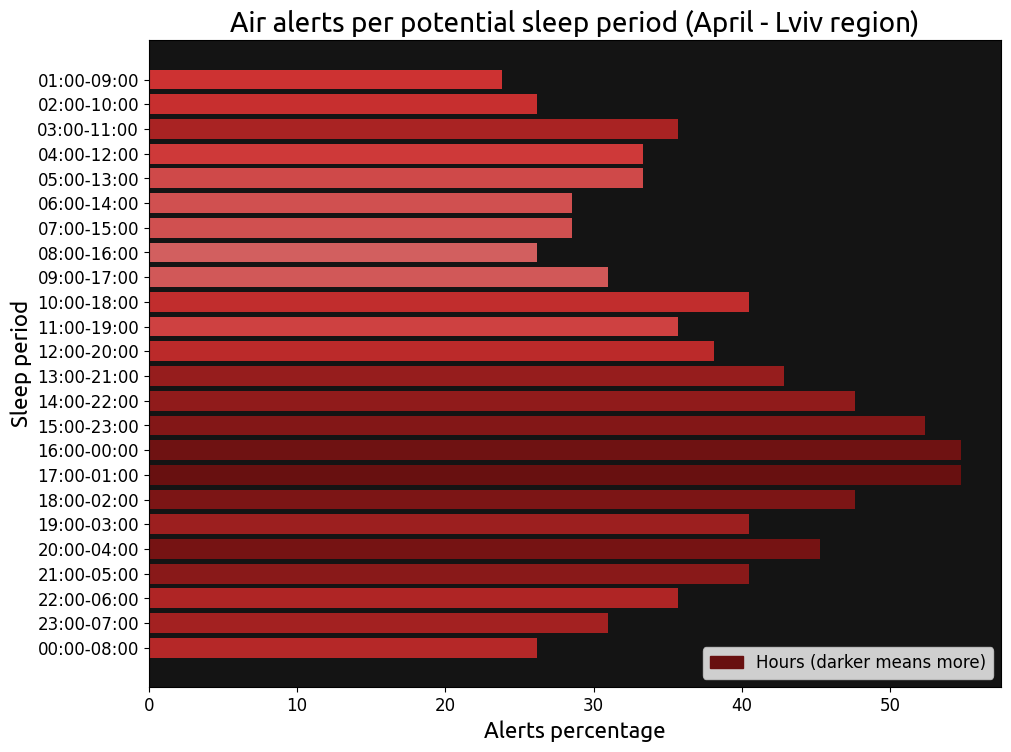

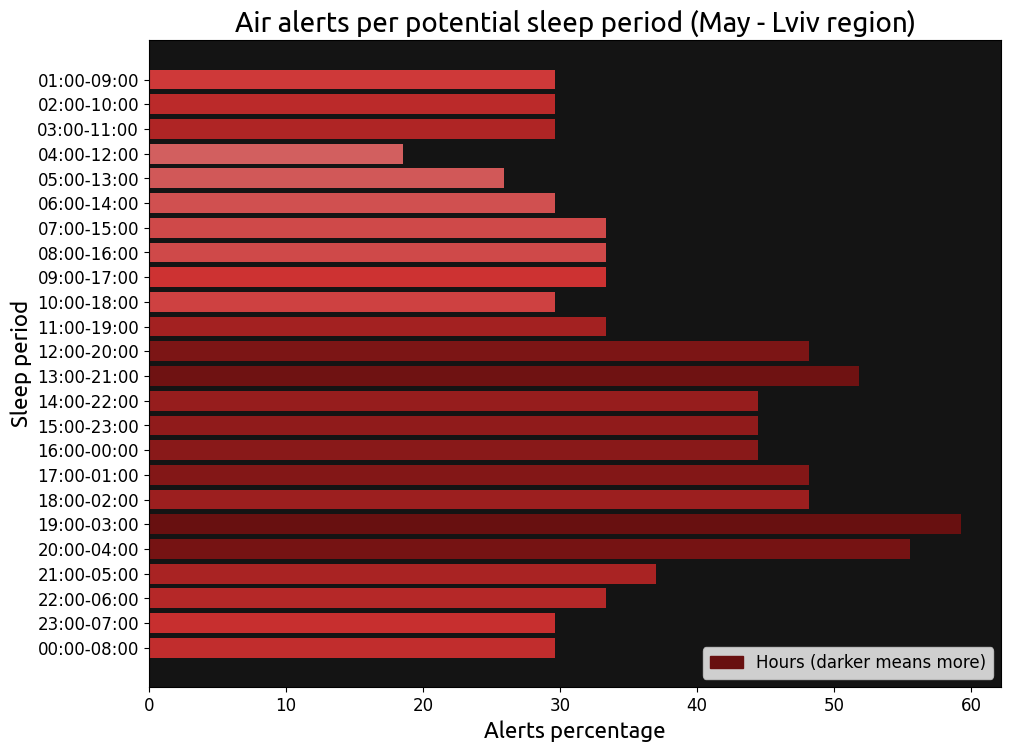

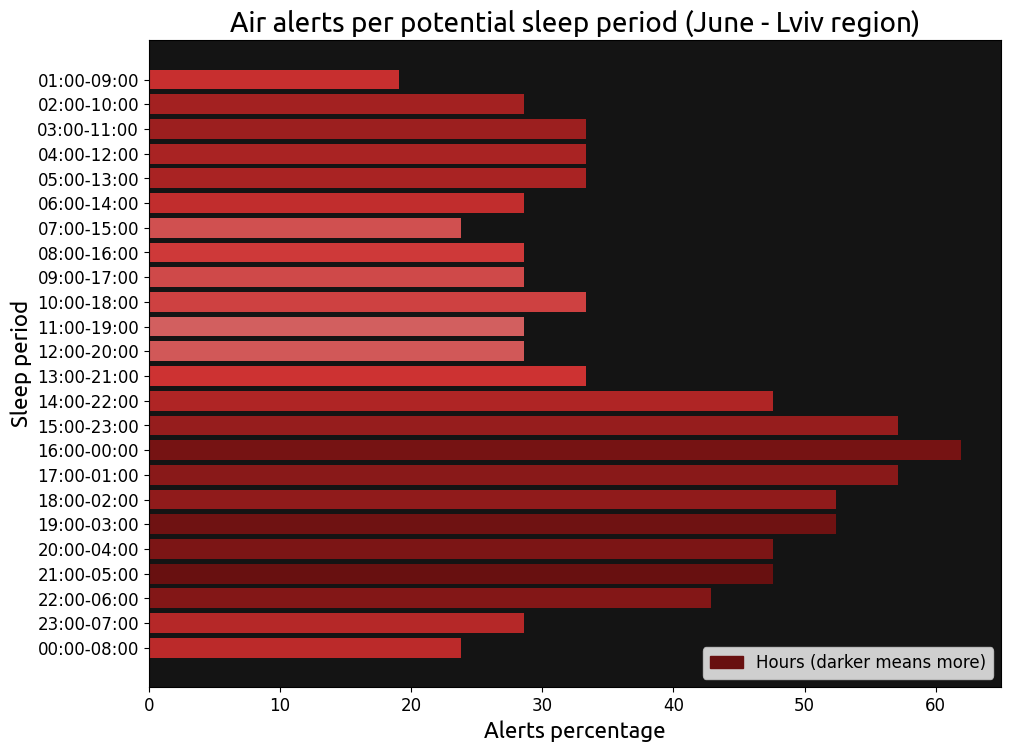

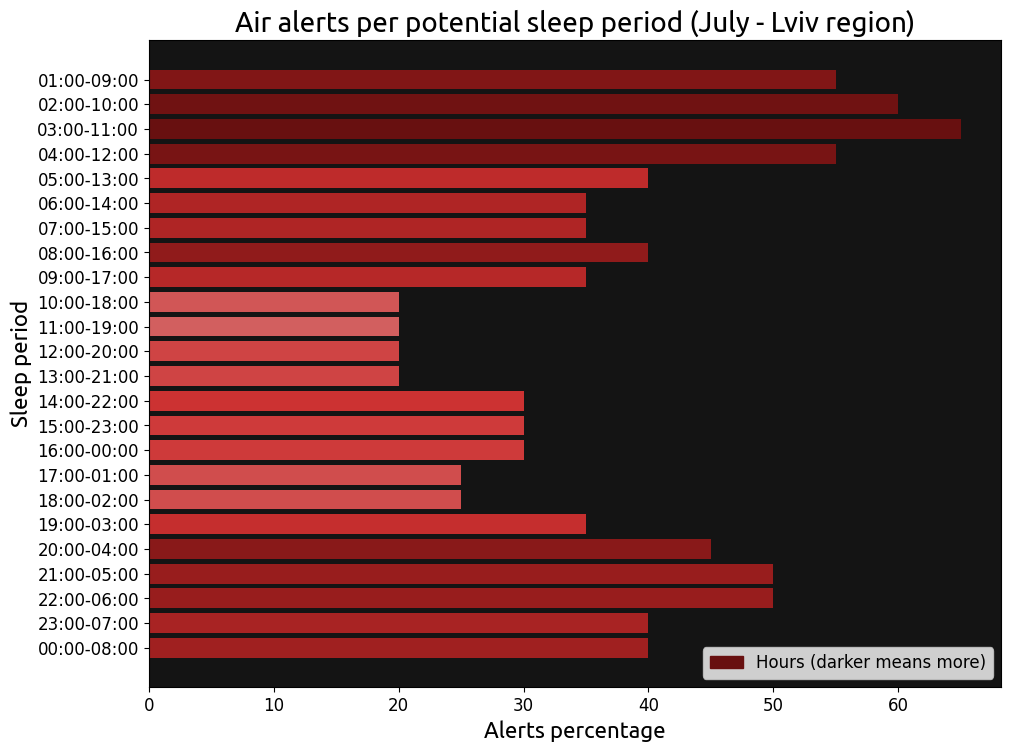

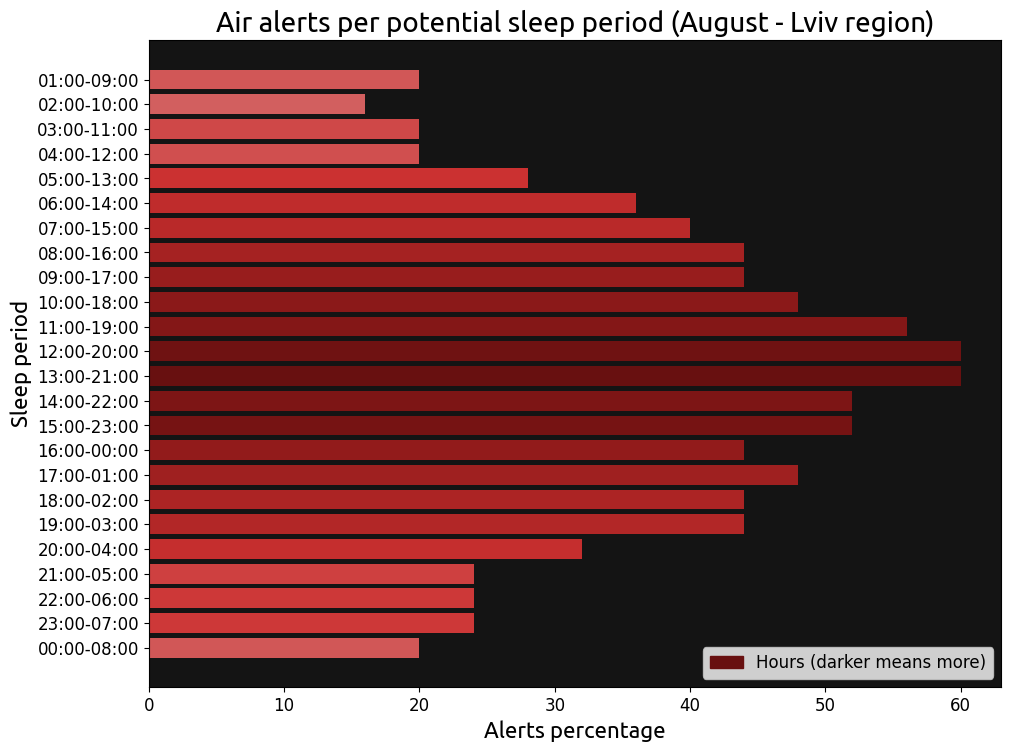

In [17]:
# Alerts per sleep period per month
for month_index, month_name in [(3, "March"), (4, "April"), (5, "May"), (6, "June"), (7, "July"), (8, "August")]:
    # Filter by month and group
    alerts_by_hour_per_month = group_alerts_by_hour(alarms_df[alarms_df["start_datetime"].dt.month == month_index])
    # Calculate alerts per sleep period per month
    alerts_per_sleep_period_per_month = combine_hours_into_sleep_periods(alerts_by_hour_per_month)
    # Plot
    alerts_per_sleep_period_per_month = alerts_per_sleep_period_per_month.sort_index(ascending=False)
    create_plot(
        alerts_per_sleep_period_per_month,
        'sleep_period', 'alerts_percetage_per_sleep_period',
        first_hex=PLOT_COLOR_LIGHT, last_hex=PLOT_COLOR_DARK,
        plot_title=f"Air alerts per potential sleep period ({month_name} - {FILTER_BY_REGION})",
        y_label="Sleep period", x_label="Alerts percentage",
        save=SAVE, animate=ANIMATE,
        plot_color_column='hours_per_sleep_period', plot_color_column_label='Hours (darker means more)'
    )